# Аналитика с применением ML. Обучение с учителем. Классификация.

## Вам необходимо построить модель-классификатор по определению диабета.

<div style="text-align: center;\">
    <img src="https://atlas.ru/blog/content/images/size/w2000/2020/11/2020-11-17-Diabetes-1.png" width="700" height="400">
</div>

In [195]:
# Импортируем нужные библиотеки
import pandas as pd # для работы с данными
import numpy as np # для вычислений
import matplotlib.pyplot as plt # для визулизаций
import seaborn as sns # для визулизаций

import plotly.graph_objects as go # для визулизаций
from plotly.subplots import make_subplots 

from sklearn.linear_model import LogisticRegression # Линейная модель
from sklearn import preprocessing # предобработка
from sklearn import metrics # метрики
from sklearn.model_selection import train_test_split # выборка
from sklearn.ensemble import RandomForestClassifier # модель RandomForest

from imblearn.over_sampling import SMOTE # для дисбаланса классов

import lightgbm as lgb # модель LightGBM
%matplotlib inline

Повторим, как организуется процесс разработки DS-проектов согласно методологии CRISP-DM.

Этапы модели CRISP-DM:
1. Анализ требований
2. Иследование данных
3. Подготовка данных
4. Моделирование
5. Оценка модели
6. Внедрение

### Анализ требований

**Нам необходимо построить модель-классификатор по определению диабета.** У вас нет никаких ограничений по инструментам, новым полям и способу энкодинга данных. Есть данные для train и для test, нужно предсказать диабет для данных test. 

**Цель: F1-score был больше 0,85**

**Знакомство с данными**

In [196]:
# Считываем данные из таблицы
df = pd.read_csv(r'data\training_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True) # удаляем ошибочную переменную "Unnamed: 0"
df.set_index("ID", inplace=True) # устанавливаем колонку "ID" как индекс
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
ID,,,,,,,,,
78830894-cdd8-43d1-9655-03db74141b7a,Female,80.0,0,1,never,25.19,6.6,140,0
32262c0e-903a-46b8-9061-b1a2f5a3e9b2,Female,54.0,0,0,No Info,27.32,6.6,80,0
c4868b73-ca90-48ed-af14-3d1f78a5f030,Male,28.0,0,0,never,27.32,5.7,158,0
bec2ef91-5aff-48df-ac16-cb210b5f29fa,Female,36.0,0,0,current,23.45,5.0,155,0
1a6852a8-ee80-4d93-bea0-f0cdd941dc3d,Male,76.0,1,1,current,20.14,4.8,155,0


На каждой строке описано медицинские данные пациента:
1. gender - Пол
2. age - Возраст
3. hypertension - Гипертония
4. heart_disease - Болезни сердца
5. smoking_history - История курения
6. bmi - Индекс массы тела
7. HbA1c_level - Уровень HbA1c
8. blood_glucose_level - Уровень глюкозы в крови
9. diabetes - Диабет (**Целевая переменная**)

In [197]:
df.shape

(73718, 9)

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73718 entries, 78830894-cdd8-43d1-9655-03db74141b7a to a98d816c-f44e-4329-930b-58466aaa0bc7
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               73718 non-null  object 
 1   age                  73718 non-null  float64
 2   hypertension         73718 non-null  int64  
 3   heart_disease        73718 non-null  int64  
 4   smoking_history      73718 non-null  object 
 5   bmi                  73718 non-null  float64
 6   HbA1c_level          73718 non-null  float64
 7   blood_glucose_level  73718 non-null  int64  
 8   diabetes             73718 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 5.6+ MB


Требуется изменить тип дынных некоторых колоннок.

In [199]:
# Изменение типа данных 'hypertension' на boolean
df['hypertension'] = df['hypertension'].astype(bool)
# Изменение типа данных 'heart_disease' на boolean
df['heart_disease'] = df['heart_disease'].astype(bool)
# Изменение типа данных 'diabetes' на boolean
df['diabetes'] = df['diabetes'].astype(bool)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73718 entries, 78830894-cdd8-43d1-9655-03db74141b7a to a98d816c-f44e-4329-930b-58466aaa0bc7
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               73718 non-null  object 
 1   age                  73718 non-null  float64
 2   hypertension         73718 non-null  bool   
 3   heart_disease        73718 non-null  bool   
 4   smoking_history      73718 non-null  object 
 5   bmi                  73718 non-null  float64
 6   HbA1c_level          73718 non-null  float64
 7   blood_glucose_level  73718 non-null  int64  
 8   diabetes             73718 non-null  bool   
dtypes: bool(3), float64(3), int64(1), object(2)
memory usage: 4.1+ MB


### Исследование данных

Цель этого шага — понять слабые и сильные стороны предоставленных данных, определить их достаточность, оценить взаимосвязи между признаками и предложить идеи, как их использовать.

Выводим описательные статистики для числовых и категориальных признаков

In [201]:
df.describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,73718.000000,73718.000000,73718.000000,73718.000000
mean,41.852959,27.348037,5.534038,138.197835
std,22.488153,6.776093,1.070917,40.892972
min,0.080000,10.010000,3.500000,80.000000
25%,24.000000,23.430000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,59.000000,29.900000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


In [202]:
df.describe(include='object')

,gender,smoking_history
count,73718,73718
unique,3,6
top,Female,never
freq,43097,26296


In [203]:
# создаем копию для облегчения работы с таблицей
temp_data = df.copy()

In [204]:
types = temp_data.dtypes # типы данных колонок
num_features = list(types[(types != 'object') & (types != 'bool')].index) # берем все численные метрики
num_features

['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

Покажем визуализацией диаграмму рассеяния для числовых признаков. Дополнительно поверх диаграммы рассеяния построим отношения с целевой переменной.

#### Визуализируем числовые признаки 

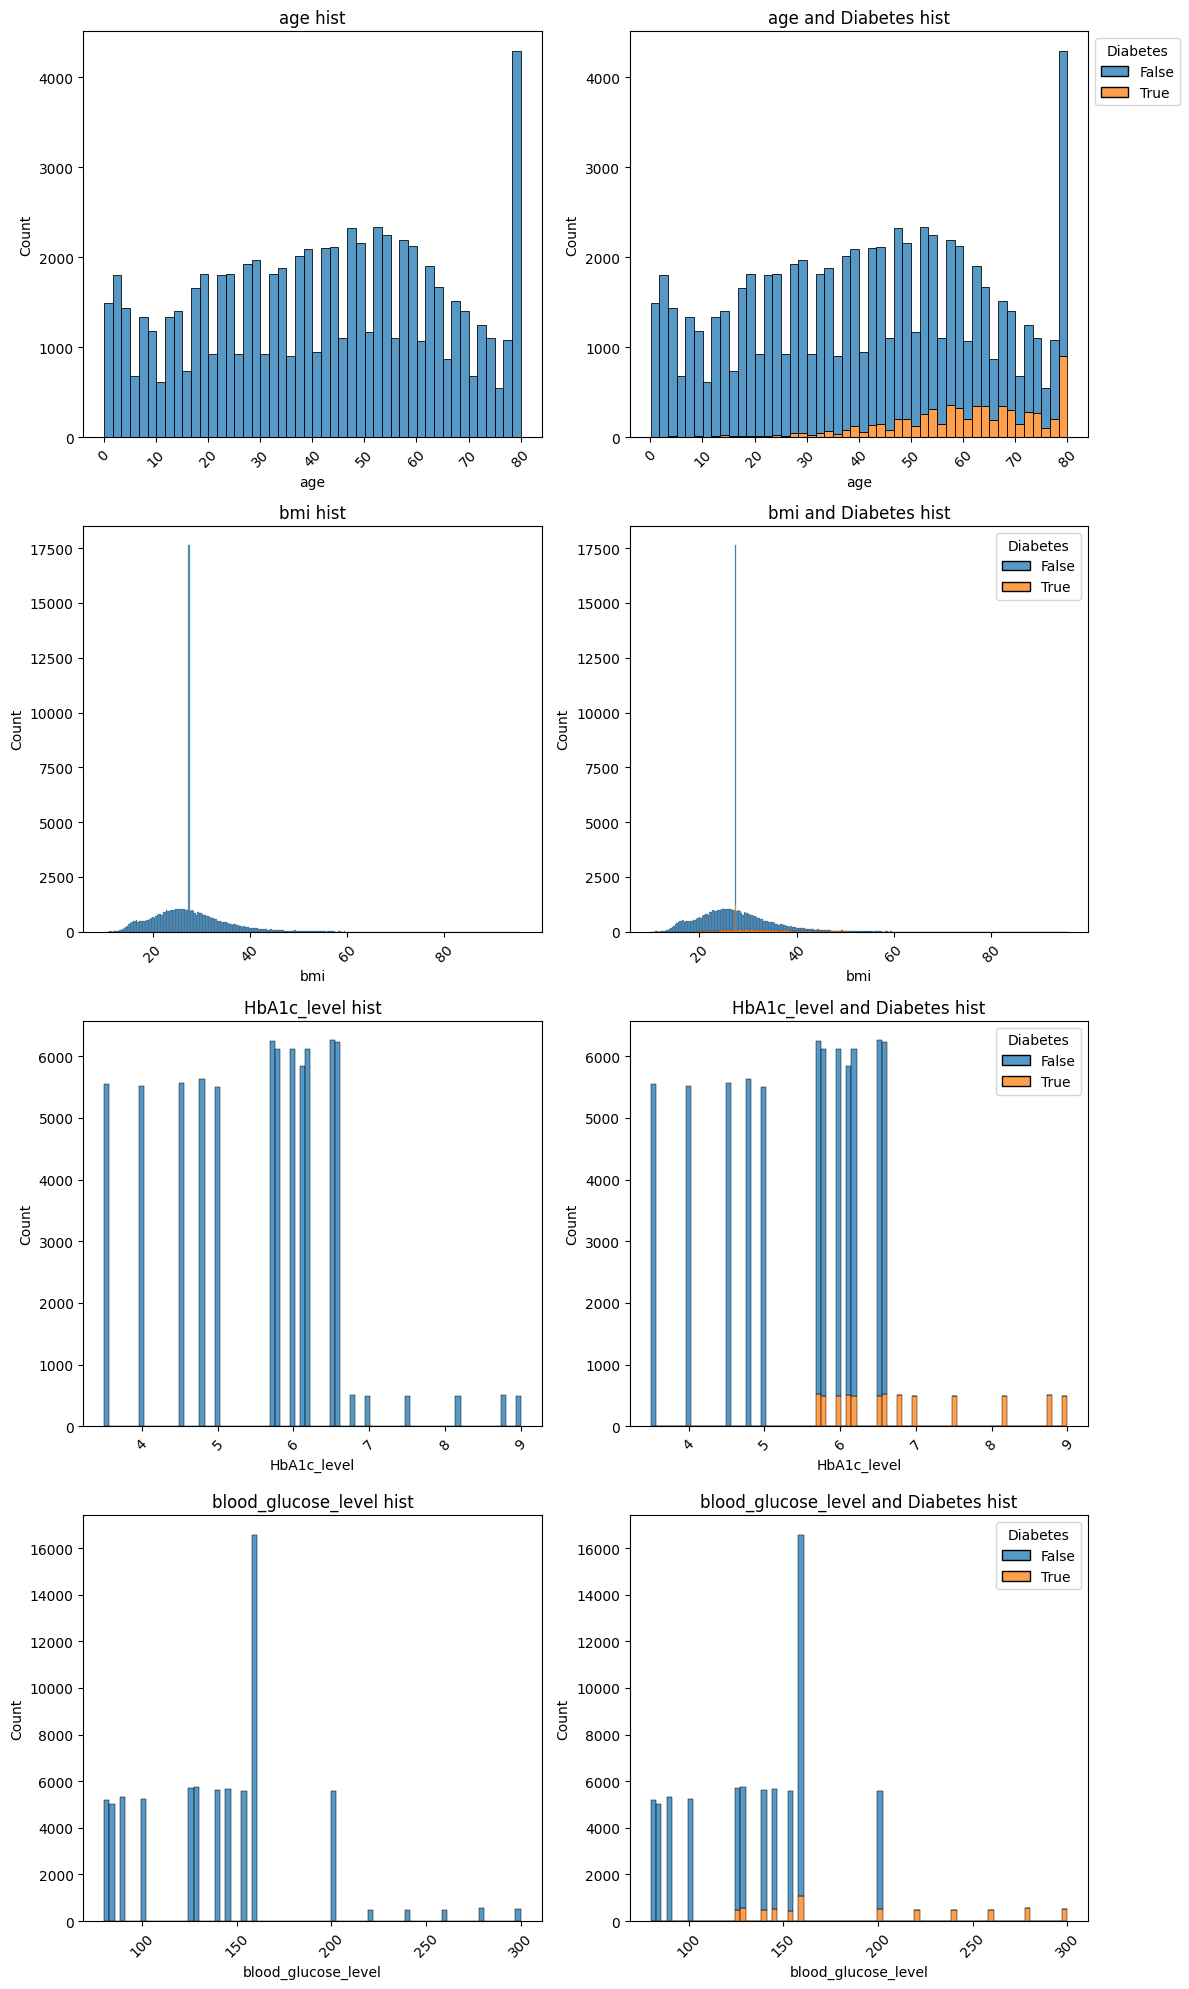

In [205]:
n = len(num_features)
fig, axis = plt.subplots(n, 2, figsize=(12, n*5))
for i, feature in enumerate(num_features):
    # Диаграмма рассеяния
    histplot_1 = sns.histplot(data=temp_data, x=feature, ax=axis[i][0])
    histplot_1.set_title('{} hist'.format(feature))
    histplot_1.xaxis.set_tick_params(rotation=45)
    # Диаграмма рассеяния + Целевая переменная
    histplot_2 = sns.histplot(data=temp_data, x=feature, hue='diabetes', multiple='stack', ax=axis[i][1])
    histplot_2.set_title('{} and Diabetes hist'.format(feature))
    histplot_2.xaxis.set_tick_params(rotation=45)
    # Добавление легенды вручную
    histplot_2.legend_.set_title('Diabetes')
    histplot_2.legend_.set_bbox_to_anchor((1, 1))
    
plt.tight_layout() # выравнивание графиков
plt.show()

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между числовыми переменнами.

<Axes: >

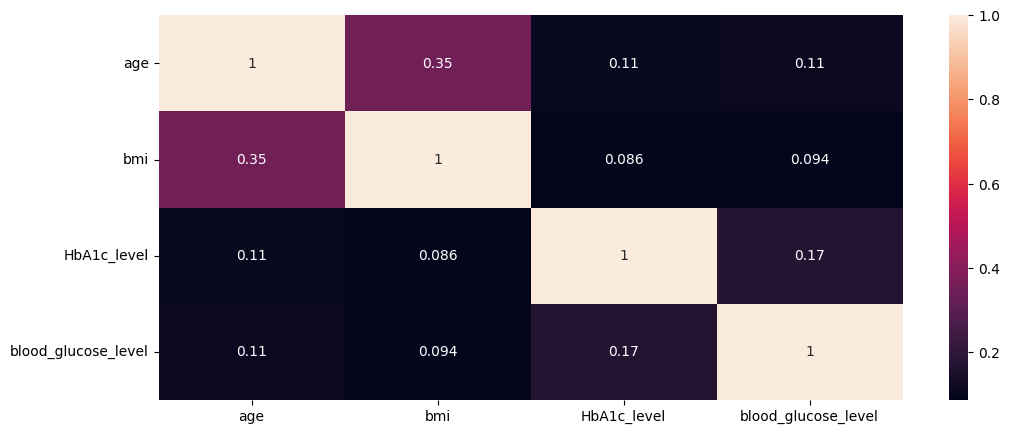

In [206]:
# Строим тепловую карту корреляций
fig, _ = plt.subplots(figsize=(12, 5))
sns.heatmap(temp_data[num_features].corr(), annot=True)

Покажем визуализацией Гистограмму для object и bool признаков и отношение к целевому признаку.

#### Визуализируем признаки типа "object"

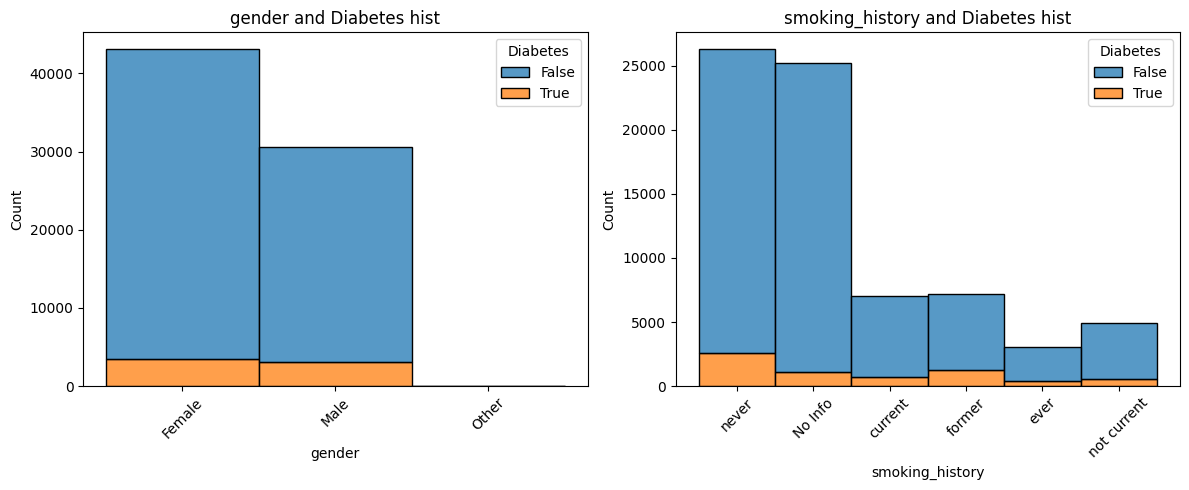

In [207]:
object_features = list(types[types == 'object'].index)

n = len(object_features)
fig, axis = plt.subplots(1, n, figsize=(n*6, 5))
for i, feature in enumerate(object_features):    
    # Гистограмма    
    histplot = sns.histplot(data=temp_data, x=feature, hue='diabetes', multiple='stack', ax=axis[i])
    histplot.set_title('{} and Diabetes hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=45)
    # Добавление легенды вручную
    histplot.legend_.set_title('Diabetes')
    histplot.legend_.set_bbox_to_anchor((1, 1))
    
plt.tight_layout() # выравнивание графиков
plt.show()

#### Визуализируем признаки типа "boolean"

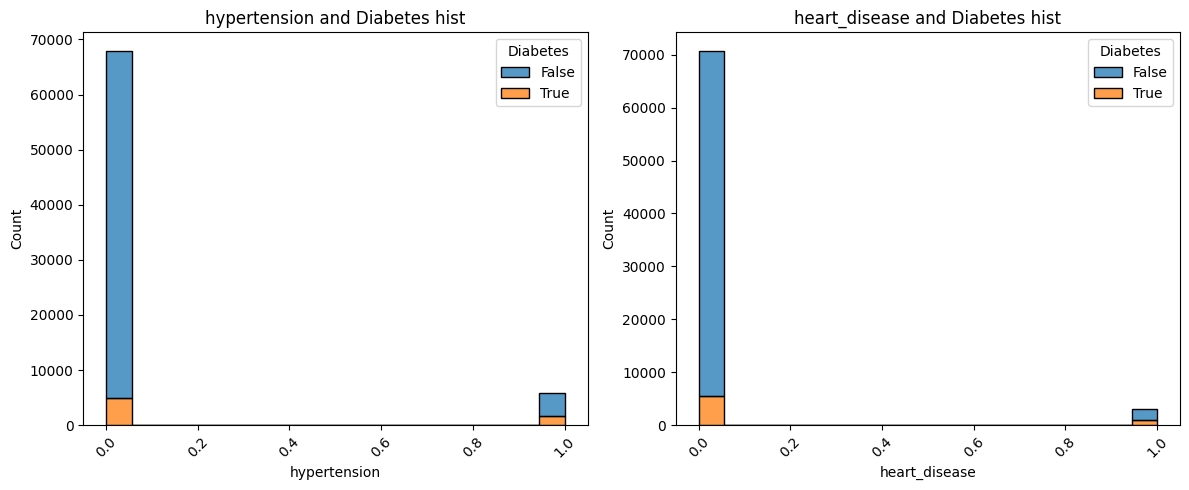

In [208]:
bool_features = list(types[types == 'bool'].index)
bool_features.pop(-1) # удалил "diabetes"

n = len(bool_features)
fig, axis = plt.subplots(1, n, figsize=(n*6, 5))
for i, feature in enumerate(bool_features):
    # Гистограмма    
    histplot = sns.histplot(data=temp_data, x=feature, hue='diabetes', multiple='stack', ax=axis[i])
    histplot.set_title('{} and Diabetes hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=45)
    # Добавление легенды вручную
    histplot.legend_.set_title('Diabetes')
    histplot.legend_.set_bbox_to_anchor((1, 1))
    
plt.tight_layout() # выравнивание графиков
plt.show()

#### Дисбаланс классов

Если посмотреть балланс между классами целевой переменны, то мы можем увидеть большой дисбаланс классов. Из за этого будущем модель покажет плохие результаты.

In [209]:
temp_data['diabetes'].value_counts()

diabetes
False    67168
True      6550
Name: count, dtype: int64

Чтобы решить **дисбаланс** между классами. Нужно использовать SMOTE на след. этапе.

### Подготовка данных

Цель этого этапа — подготовить обучающую выборку для использования в моделировании.

**Модель:** Классификация

**Задачи:**
* Анализ дубликатов
* Анализ пустот
* Удаление выбросов
* Обработать числовые метрики
* Обработать категориальные метрики
* Удаление лишних метрик

#### Анализ дубликатов

Выводим дубликаты с помощью функции duplicated() и удаляем их функцией drop_duplicates().

In [210]:
# Выводим количество данных
temp_data.shape[0]

73718

In [211]:
# Выводим дубликаты
temp_data[temp_data.duplicated()]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
ID,,,,,,,,,
1aba46f7-e49e-4824-9cb8-15e11588d477,Female,60.0,False,False,never,23.77,6.1,140,False
98921651-571e-45bc-8faa-b49bb66e36db,Male,53.0,False,False,current,25.45,6.8,145,True
bfda2231-30e0-4190-9ac9-4c88ceabb89f,Female,66.0,False,False,No Info,24.00,4.5,85,False
4ceb4536-5372-4e57-a0ff-3fca96e6b395,Female,10.0,False,False,No Info,20.35,6.0,140,False
412c6a9a-e142-4497-b077-bd834275e302,Female,7.0,False,False,never,31.71,6.5,159,False
...,...,...,...,...,...,...,...,...,...
5c890971-a6d7-44ce-a8a1-3b38cda7ef3b,Female,70.0,True,False,never,55.57,6.2,130,True
13a8f177-1623-4acf-9db8-1e8ac8577c86,Male,60.0,False,False,No Info,27.32,6.6,160,False
c9539d1b-075f-481f-8ae4-ab9bba75af5b,Male,65.0,False,False,former,32.07,5.0,160,False


In [212]:
# Удаляем дубликаты
temp_data = temp_data.drop_duplicates()

In [213]:
# Новое количество данных
temp_data.shape[0]

70000

Были удалены 3718 строк данных которые были дубликатами.

#### Анализ пустот

Для анализа пустот в данных используем isna()

In [214]:
# Выводим количество пустых ячеек из каждой колонки нашего датасета 
temp_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Пустые ячейки отсутствуют.

#### Удаление выбросов

Цель - удалить выбросы у численных метрик. Если посмотреть на распределение всех числовых признаков, я считаю что я могу удалить выбросы толоко из колонки "bmi". Потому что при удалении выбросов из других численных метрик я могу удалить большую часть класса номер 1. Но удалять выбросы и с "bmi" тоже опасно.

In [215]:
def viz_2(temp_data, col_name, target):
    fig, axis = plt.subplots(1, 1, figsize=(7, 4))
    
    Q1 = np.percentile(temp_data[col_name], 25)
    Q3 = np.percentile(temp_data[col_name], 75)
    IQR = Q3-Q1

    bmi_lower_line = temp_data[col_name].median() - 1.5*IQR
    bmi_upper_line = temp_data[col_name].median() + 1.5*IQR

    histplot_2 = sns.histplot(temp_data, x = col_name, hue=target, multiple='stack')
    histplot_2.set_title("{} and 3q".format(col_name))
    histplot_2.xaxis.set_tick_params(rotation=45)
    histplot.legend_.set_title('Diabetes')
    histplot.legend_.set_bbox_to_anchor((1, 1))
    
    # axis.axvline(temp_data[col_name].median(), color='k', lw=2)
    axis.axvline(bmi_lower_line, color='k', ls='--', lw=2)
    axis.axvline(bmi_upper_line, color='k', ls='--', lw=2)
    
    plt.show()
    
    return bmi_lower_line, bmi_upper_line



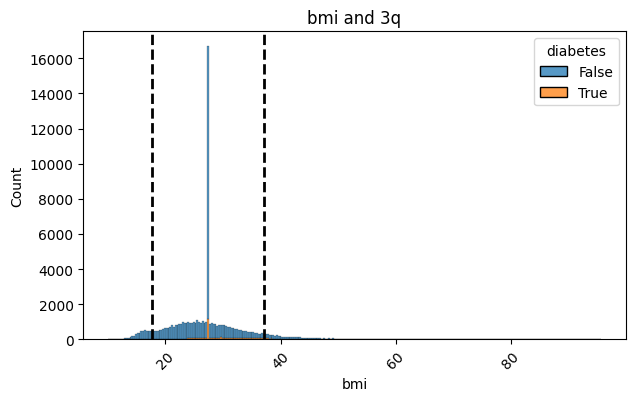

In [216]:
bmi_lower_line, bmi_upper_line = viz_2(temp_data, 'bmi', 'diabetes')

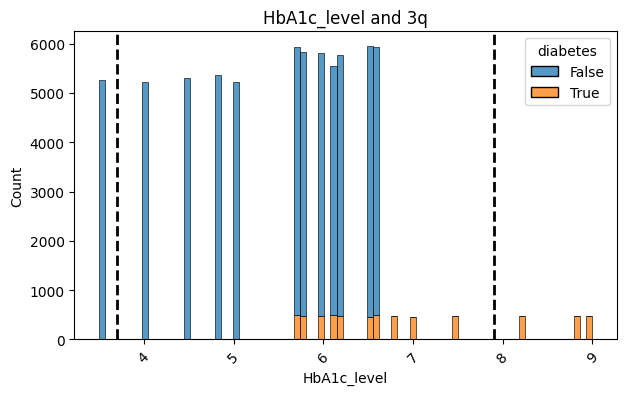

(np.float64(3.6999999999999993), np.float64(7.9))

In [217]:
viz_2(temp_data, 'HbA1c_level', 'diabetes')

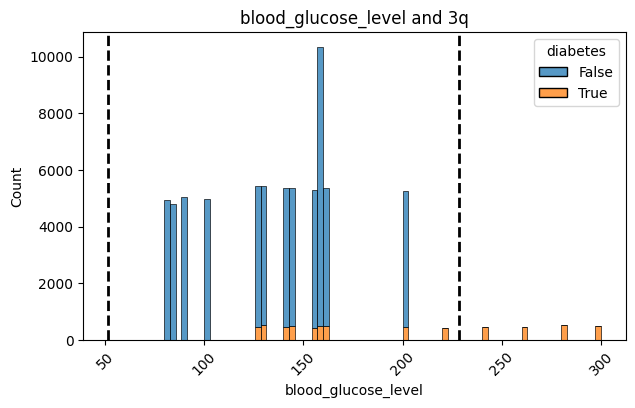

(np.float64(51.5), np.float64(228.5))

In [218]:
viz_2(temp_data, 'blood_glucose_level', 'diabetes')

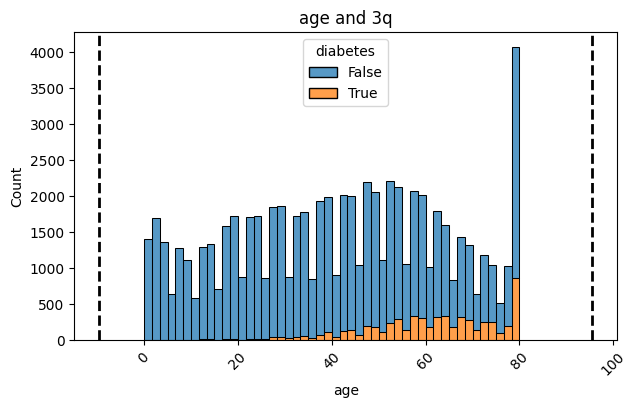

(np.float64(-9.5), np.float64(95.5))

In [219]:
viz_2(temp_data, 'age', 'diabetes')

In [220]:
temp_data[(temp_data['bmi'] < bmi_lower_line) | (temp_data['bmi'] > bmi_upper_line)]['diabetes'].value_counts()

diabetes
False    9041
True     1386
Name: count, dtype: int64

В этом отрезке я не собираюсь удалить "выбросы" с bmi. Посмотрим как это скажется на дынных.

#### Обработать числовые метрики

Цель - нормализовать числовые метрики, чтобы в начале обучения они имели одинаковую силу влияния. Нам надо номализовать их в отрезке     [0, 5]. Для этого я использую метод **MinMAx()**. 

**Аналитически любая нормализация сводится к формуле**

$$Xнорм = (Xi - Xсмещ)/Xед$$



где 

* $Xi$ — текущее значение,
* $Xсмещ$ — величина смещения значений,
* $Xед$ — величина интервала, который будет преобразован к “единице”


**Минимакс (MinMax).** Цель — преобразовать исходный набор в диапазон [0..1]. Для него:

$Xсмещ$= $Xмин$, минимальное значение исходных данных.

$Xед$ = $Xмакс$ — $Xмин$, т.е. за “единичный” интервал берется исходный диапазон значений.

In [221]:
# Добавил диапазон [0, 10]
scaler = preprocessing.MinMaxScaler(feature_range=(0, 10))
temp_data[num_features] = scaler.fit_transform(temp_data[num_features])

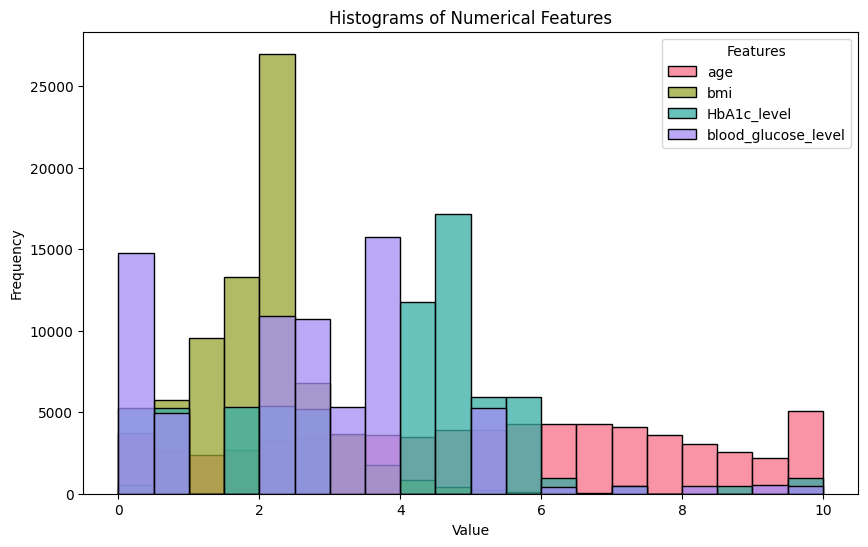

In [222]:
plt.figure(figsize=(10, 6))

# Цветовая палитра
palette = sns.color_palette("husl", len(num_features))

# Рисуем гистограммы для каждого числового признака
for i, feature in enumerate(num_features):
    sns.histplot(temp_data[feature], color=palette[i], label=feature, kde=False, binwidth=0.5)

# Добавляем легенду
plt.legend(title='Features')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Numerical Features')
plt.show()

#### Обработать категориальные метрики

Произведем One Hot-кодирование категориальных признаков с помощью функции pandas - get_dummies().

In [223]:
#Производим кодирование категориальных признаков
dummies_data = pd.get_dummies(temp_data)
dummies_data.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
ID,,,,,,,,,,,,,,,,
78830894-cdd8-43d1-9655-03db74141b7a,10.000000,False,True,1.771709,5.636364,2.727273,False,True,False,False,False,False,False,False,True,False
32262c0e-903a-46b8-9061-b1a2f5a3e9b2,6.746747,False,False,2.020308,5.636364,0.000000,False,True,False,False,True,False,False,False,False,False
c4868b73-ca90-48ed-af14-3d1f78a5f030,3.493493,False,False,2.020308,4.000000,3.545455,False,False,True,False,False,False,False,False,True,False
bec2ef91-5aff-48df-ac16-cb210b5f29fa,4.494494,False,False,1.568627,2.727273,3.409091,False,True,False,False,False,True,False,False,False,False
1a6852a8-ee80-4d93-bea0-f0cdd941dc3d,9.499499,True,True,1.182306,2.363636,3.409091,False,False,True,False,False,True,False,False,False,False


In [224]:
dummies_data.shape

(70000, 16)

#### Удаление лишних метрик

Цель - удалить признаки которые имеют низкую значимость. Чтобы это сделать я использовал LightGBM.

**Light Gradient Boosted Machine (LightGBM)** — эффективную реализацию ансамбля стохастического градиентного бустинга с открытым исходным кодом. 

Градиентный бустинг относится к классу ансамблевых алгоритмов машинного обучения, которые могут использоваться для задач классификации или регрессионного прогностического моделирования.

У LightGBM есть метод **.feature_importance()** он показывает значимость метрики для прогнозирования. Так можно сортировать метрики по значимости. 

In [225]:
X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
y = dummies_data['diabetes']   # Ваши целевые переменные

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание набора данных LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Задание параметров модели
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'dart'
}

model = lgb.LGBMClassifier()

# Обучение модели
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Получение важности признаков
importance = model.feature_importance()
feature_names = X_train.columns

# Создание DataFrame для удобного анализа
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})

# Сортировка признаков по важности
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Вывод важных признаков
print(feature_importance_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4957, number of negative: 51043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088518 -> initscore=-2.331868
[LightGBM] [Info] Start training from score -2.331868
                        feature  importance
3                           bmi         705
5           blood_glucose_level         675
0                           age         586
4                   HbA1c_level         446
1                  hypertension         137
9       smoking_hist

In [226]:
dummies_data = dummies_data.drop('gender_Other', axis=1)

In [227]:
dummies_data = dummies_data[-((dummies_data['gender_Male'] == False) & (dummies_data['gender_Female']==False))]

## Итерация #1

### Моделирование + Оценка модели

In [228]:
# Функция для удобства
def metrics_print(y_test, y_pred):
    print(f"\nf1-score: {metrics.f1_score(y_test, y_pred)}")
    print(f"precision: {metrics.precision_score(y_test, y_pred)}")
    print(f"recall: {metrics.recall_score(y_test, y_pred)}")
    print(f"confusion matrix: \n{metrics.confusion_matrix(y_test, y_pred)}")

In [229]:
X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
y = dummies_data['diabetes']   # Ваши целевые переменные

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаю базывую модель LogisticRegression(), но добавляю class_weight.
# Потому что у нас дисбаланс классов.
model = LogisticRegression(class_weight='balanced', random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказываем X_test
y_pred = model.predict(X_test)
# Выводим ошибку
metrics_print(y_test, y_pred)


f1-score: 0.5848508841382951
precision: 0.434850863422292
recall: 0.8928283642224013
confusion matrix: 
[[11317  1440]
 [  133  1108]]


## Итерация #2

* Нужно попробывать обьеденить колонки про курение 
* Нужно использовать SMOTE только для числовых признаков
* Попробывать на более сложной модели и сравнить модели
* Сделать тюнинг модели 

#### 1) Нужно попробывать обьеденить колонки про курение

У нас в категориальном признаке "smoking_history" есть 6 класса: never(Никогда), No Info (Нет информации), former (Бывший), current (Настоящее время), not current (Бывший), ever(Когда-либо). 

Я собираюсь обьединить в 3 класса: Never (никогда), No_info (Нет информации) и Ever(Когда-либо). Нужно еще попробывать удалить класс No_info, потому что по логике она считается выбросом. 

In [189]:
# Уникальные занчения в колонке smoking_history и подчет количество
temp_data['smoking_history'].value_counts()

smoking_history
never          25010
No Info        23957
former          6787
current         6663
not current     4684
ever            2899
Name: count, dtype: int64

In [190]:
# # Функция для перезаписи значений
# def rewrite_class(value):
#     if value == 'former' or value=='current' or value=='not current' or value=='ever':
#         return 'ever' # когдо либо
#     elif value == 'never':
#         return 'never' # никогда
#     else:
#         return 'no_info' # нет инфо
    
# # Перезаписываю класс История курения на 3 класса
# temp_data['smoking_history'] = temp_data['smoking_history'].apply(rewrite_class)

In [191]:
# Баланс между классами
temp_data['smoking_history'].value_counts()

smoking_history
never          25010
No Info        23957
former          6787
current         6663
not current     4684
ever            2899
Name: count, dtype: int64

In [192]:
# no_info_temp_data = temp_data[temp_data['smoking_history'] == "No Info"] # нет инфо

In [193]:
# Результат после перераспределения на классы в "smoking_history"
dummies_data = pd.get_dummies(temp_data)
dummies_data = dummies_data.drop('gender_Other', axis=1)

X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
y = dummies_data['diabetes']   # Ваши целевые переменные

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаю базывую модель LogisticRegression(), но добавляю class_weight.
# Потому что у нас дисбаланс классов.
model = LogisticRegression(class_weight='balanced', random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказываем X_test
y_pred = model.predict(X_test)
# Выводим ошибку
metrics_print(y_test, y_pred)


f1-score: 0.5744512033853478
precision: 0.42789598108747046
recall: 0.8736926790024135
confusion matrix: 
[[11305  1452]
 [  157  1086]]


c:\Users\moona\Desktop\диабет\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [194]:
# # Результат после удаления класса "no_info" в "smoking_history"
# dummies_data = pd.get_dummies(no_info_temp_data)
# dummies_data = dummies_data.drop('gender_Other', axis=1)

# X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
# y = dummies_data['diabetes']   # Ваши целевые переменные

# # Разделение данных на обучающие и тестовые
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Создаю базывую модель LogisticRegression(), но добавляю class_weight.
# # Потому что у нас дисбаланс классов.
# model = LogisticRegression(class_weight='balanced', random_state=42)

# # Обучаем модель
# model.fit(X_train, y_train)

# # Предсказываем X_test
# y_pred = model.predict(X_test)
# # Выводим ошибку
# metrics_print(y_test, y_pred)


f1-score: 0.41488162344983087
precision: 0.2713864306784661
recall: 0.8803827751196173
confusion matrix: 
[[4089  494]
 [  25  184]]


Результат знизился так что я пока собираюсь оставить все как есть

#### 2) Нужно использовать SMOTE только для числовых признаков (SMOTE with num_features)

In [243]:
# Количество в классах Целевой метрики (diabetes)  
y.value_counts()

diabetes
False    63800
True      6200
Name: count, dtype: int64

In [245]:
# Попробуем обучить модель только на числовых признаках (num_features)
X_numeric = dummies_data[num_features] # Признаки
y = dummies_data['diabetes'] # Целевое переменное

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Создаем модель
model = LogisticRegression(class_weight='balanced', random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказываем X_test и X_train
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Выводим ошибку на train и на test
print("Train:")
metrics_print(y_train, y_train_pred)
print("\nTest:")
metrics_print(y_test, y_pred)

Train:

f1-score: 0.5675516993933069
precision: 0.4193983802545314
recall: 0.8775469033689731
confusion matrix: 
[[45021  6022]
 [  607  4350]]

Test:

f1-score: 0.5660474716202271
precision: 0.416635017090771
recall: 0.8825422365245374
confusion matrix: 
[[11221  1536]
 [  146  1097]]


Результат знизился конечно, но не так сильно как я себе представлял. Теперь попробуем использовать SMOTE только на числовых признаков.

**SMOTE** (Synthetic Minority Oversampling Technique) - это метод подготовки **несбалансированного** датасета к загрузке в модель машинного обучения, предполагающий не просто дублировать, а создать новые, синтетические примеры, чтобы улучшить представление меньшинств и сбалансировать данные.

SMOTE использует очень простой подход:

<div style="text-align: center;\">
    <img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*n8cNY6_B6FYP7ktbNEnR5Q.png" width="500" height="400">
</div>

1. Случайным образом выберите выборку, назовем ее O (для Origin), из класса меньшинств.
2. Найдите K ближайших соседей O, которые принадлежат к тому же классу.
3. Соедините O с каждым из этих соседей прямой линией
4. Случайным образом выберите масштабный коэффициент 'z' в диапазоне [0,1].
5. Для каждого нового соединения поместите новую точку на прямой (z*100)% от O. Это будут наши синтетические образцы.
6. Повторяйте этот процесс, пока не получите нужное количество синтетических образцов


**Важно !!!**

Хотя идея генерирования новых синтетических образцов вместо дублирования оригинальных образцов является шагом вперед, у SMOTE есть один главный недостаток. Если точка, выбранная на шаге 1 или 2, находится в области, где доминируют образцы мажоритарного класса, синтетические точки могут быть сгенерированы внутри области мажоритарного класса (**что может затруднить классификацию!**).

In [246]:
# Количество в классах Целевой метрики (diabetes) в y_train
y_train.value_counts()

diabetes
False    51043
True      4957
Name: count, dtype: int64

In [263]:
# Используем SMOTE
# SMOTE надо использовать только на X_train
X_numeric = dummies_data[num_features] # Признаки
y = dummies_data['diabetes'] # Целевое переменное

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

smote_pre = SMOTE(random_state=42, k_neighbors=3)
X_smote, y_smote = smote_pre.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42)

# Обучаем модель
model.fit(X_smote, y_smote)

# Предсказываем X_test
y_pred = model.predict(X_test)
# Выводим ошибку
print('Test: ')
metrics_print(y_test, y_pred)

Test: 

f1-score: 0.5687548739277359
precision: 0.4201228878648233
recall: 0.8801287208366855
confusion matrix: 
[[11247  1510]
 [  149  1094]]


Есть улучшение на 0,02 на тесте. Нужно попробывать с более сложными моделями чтобы понять что лучше.

In [258]:
# Количество в классах Целевой метрики (diabetes) в y_train после SMOTE
y_smote.value_counts()

diabetes
False    51043
True     51043
Name: count, dtype: int64

#### 3) Попробывать на более сложной модели и сравнить модели (XGBOOST and RandomForest)

In [236]:
dummies_data = pd.get_dummies(temp_data)
dummies_data = dummies_data.drop('gender_Other', axis=1)

X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
y = dummies_data['diabetes']   # Ваши целевые переменные

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMClassifier(n_jobs=-1, class_weight='balanced', random_state=42, boosting_type='dart', 
                               learning_rate=0.1, n_estimators=200, reg_lambda=0.1)

lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)
y_train_pred = lgb_model.predict(X_train)

metrics_print(y_train, y_train_pred)
metrics_print(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4957, number of negative: 51043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

f1-score: 0.6626802673232501
precision: 0.508749189889825
recall: 0.9501714746822675
confusion matrix: 
[[46495  4548]
 [  247  4710]]

f1-score: 0.6298157453936348
precision: 0.48225737494655835
recall: 0.9074818986323411
confusion matrix: 
[[11546  1211]
 [  115  1128]]


LightGBM + SMOTE data

In [237]:
# use SMOTE + all features
smote_pre = SMOTE(random_state=42)
X_smote, y_smote = smote_pre.fit_resample(X_train, y_train)

lgb_model = lgb.LGBMClassifier(n_jobs=-1, random_state=42, boosting_type='dart', 
                               learning_rate=0.1, n_estimators=200, reg_lambda=0.1)

lgb_model.fit(X_smote, y_smote)

y_pred = lgb_model.predict(X_test)
y_train_pred = lgb_model.predict(X_train)

metrics_print(y_train, y_train_pred)
metrics_print(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 51043, number of negative: 51043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 102086, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

f1-score: 0.8021152829190904
precision: 0.8430413517118719
recall: 0.764978817833367
confusion matrix: 
[[50337   706]
 [ 1165  3792]]

f1-score: 0.7821276595744681
precision: 0.8301716350496838
recall: 0.7393403057119872
confusion matrix: 
[[12569   188]
 [  324   919]]


In [238]:
# use SMOTE
X_numeric = dummies_data[num_features]
y = dummies_data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

smote_pre = SMOTE(random_state=42)
X_smote, y_smote = smote_pre.fit_resample(X_train, y_train)

lgb_model = lgb.LGBMClassifier(n_jobs=-1, random_state=42, boosting_type='dart', 
                               learning_rate=0.1, n_estimators=200, reg_lambda=0.1)

lgb_model.fit(X_smote, y_smote)

y_pred = lgb_model.predict(X_test)
y_train_pred = lgb_model.predict(X_train)

metrics_print(y_train, y_train_pred)
metrics_print(y_test, y_pred)

[LightGBM] [Info] Number of positive: 51043, number of negative: 51043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 102086, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

f1-score: 0.7518153044125861
precision: 0.6980121002592913
recall: 0.8146056082307848
confusion matrix: 
[[49296  1747]
 [  919  4038]]

f1-score: 0.7176252319109462
precision: 0.6659779614325069
recall: 0.7779565567176187
confusion matrix: 
[[12272   485]
 [  276   967]]


RandomForest

In [239]:
dummies_data = pd.get_dummies(temp_data)
dummies_data = dummies_data.drop('gender_Other', axis=1)

X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
y = dummies_data['diabetes']   # Ваши целевые переменные

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42, n_estimators=200,
                                  max_features='sqrt')

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

metrics_print(y_train, y_train_pred)
metrics_print(y_test, y_pred)


f1-score: 0.9967826261813795
precision: 0.9935858889557025
recall: 1.0
confusion matrix: 
[[51011    32]
 [    0  4957]]

f1-score: 0.7867924528301887
precision: 0.95096921322691
recall: 0.670957361222848
confusion matrix: 
[[12714    43]
 [  409   834]]


In [240]:
# use SMOTE
X_numeric = dummies_data[num_features]
y = dummies_data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

smote_pre = SMOTE(random_state=42)
X_smote, y_smote = smote_pre.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=200,
                                  max_features='sqrt')

rf_model.fit(X_smote, y_smote)

y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

metrics_print(y_train, y_train_pred)
metrics_print(y_test, y_pred)


f1-score: 0.9793384223918575
precision: 0.988290879211175
recall: 0.9705467016340529
confusion matrix: 
[[50986    57]
 [  146  4811]]

f1-score: 0.7268351383874849
precision: 0.7248
recall: 0.7288817377312953
confusion matrix: 
[[12413   344]
 [  337   906]]


In [241]:
dummies_data = pd.get_dummies(temp_data)
dummies_data = dummies_data.drop('gender_Other', axis=1)

X = dummies_data.drop('diabetes', axis=1)  # Ваши признаки
y = dummies_data['diabetes']   # Ваши целевые переменные

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote_pre = SMOTE(random_state=42)
X_smote, y_smote = smote_pre.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=200,
                                  max_features='sqrt')

rf_model.fit(X_smote, y_smote)

y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

metrics_print(y_train, y_train_pred)
metrics_print(y_test, y_pred)


f1-score: 0.9967689822294022
precision: 0.9977764301596928
recall: 0.9957635666733912
confusion matrix: 
[[51032    11]
 [   21  4936]]

f1-score: 0.7486889874949576
precision: 0.7508090614886731
recall: 0.7465808527755431
confusion matrix: 
[[12449   308]
 [  315   928]]
